In [1]:
import bempp.api
import numpy as np
import dolfin

In [2]:
from dolfin import *     
from dolfin_utils.meshconvert import meshconvert

bempp.api.global_parameters.quadrature.medium.single_order = 10
bempp.api.global_parameters.quadrature.medium.double_order = 10

BEM_u_error = []
BEM_lambda_error = []
error_conv = []

mesh_size = []
iter_num = []

########################################################################
grid_size = [1, 2, 3, 4, 5, 6]#, 7, 8]
 
tol=1e-8

# ################################### Example 1 #############################################
# def f(x, n, d, res):
#     res[0] = 1/(np.sqrt(x[0]**2+x[1]**2+x[2]**2)) + 1/(np.sqrt((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2))

# def g(x, n, d, res):
#     grad = np.array([
#             -x[0]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)) - 10.0*(10.0*x[0]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0)),
#             -x[1]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)) - 10.0*(10.0*x[1]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0)),
#             -x[2]/((x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)) - 10.0*(10.0*x[2]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0))
#         ])
#     res[0] = np.dot(grad, n)
    
################################### Example 2 #############################################    
def f(x, n, d, res):
    res[0] = 1/(4.0*np.pi*np.sqrt(x[0]**2+x[1]**2+x[2]**2)) 

def g(x, n, d, res):
    grad = np.array([
            -x[0]/(4.*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
            -x[1]/(4.*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0)),
            -x[2]/(4.*np.pi*(x[0]**2+x[1]**2+x[2]**2)**(3.0/2.0))
        ])
    res[0] = np.dot(grad, n)
    
    
# ################################### Example 3 #############################################    
# def f(x, n, d, res):
#     res[0] = 1/(np.sqrt((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2))
    
# def g(x, n, d, res):
#     grad = np.array([
#             -10.0*(10.0*x[0]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0)),
#             -10.0*(10.0*x[1]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0)),
#             -10.0*(10.0*x[2]-1)/(((10.0*x[0]-1)**2+(10.0*x[1]-1)**2+(10.0*x[2]-1)**2)**(3.0/2.0))
#         ])
#     res[0] = np.dot(grad, n)


In [3]:
from dolfin import *     
from dolfin_utils.meshconvert import meshconvert
import pylab as plt
from bempp.api import fenics_interface
from bempp.api.fenics_interface import FenicsOperator
from scipy.sparse.linalg.interface import LinearOperator
from scipy.sparse.linalg import gmres

parameters["allow_extrapolation"] = True 

for m in grid_size:
    ######################### Mesh and spaces ##################################
    h = 1./2**(m/2.)
    grid = bempp.api.shapes.sphere(h=h)
    trace_space = bempp.api.function_space(grid, "P", 1) 
    bempp_space = bempp.api.function_space(grid, "P", 1)   
    
    ######################### maximum h ##################################
    hmax = 0
    for element in  list(grid.leaf_view.entity_iterator(0)):
        hmax = max(hmax,element.geometry.volume**(0.5))

    print(hmax)
    mesh_size.append(hmax)
    
    ######################### BEM variables ##################################
    f_fun = bempp.api.GridFunction(trace_space, fun=f)
    g_fun = bempp.api.GridFunction(bempp_space, fun=g)
    
    epsilon = 1.0/300.0
    alpha = 0.01
    beta_D = alpha/hmax
    beta_N = alpha*hmax
    beta = (epsilon/beta_N + beta_D)/(epsilon + 1.0)    
            
    ######################### LHS ##################################
    # The rhs from the BEM
    multi = bempp.api.BlockedOperator(2,2)
    multi[0,0] = -bempp.api.operators.boundary.laplace.double_layer(trace_space, trace_space, bempp_space)
    multi[0,1] =  bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, bempp_space)
    multi[1,0] =  bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, trace_space)
    multi[1,1] =  bempp.api.operators.boundary.laplace.adjoint_double_layer(bempp_space, bempp_space, trace_space)

    diri = bempp.api.BlockedOperator(2,2)
    diri[0,0] =  0.5 * ((epsilon*beta-1.0)/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(trace_space, trace_space, bempp_space)
    diri[0,1] = -(epsilon/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(bempp_space, trace_space, bempp_space)
    diri[1,0] = -(beta/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, trace_space)
    diri[1,1] = -0.5 * ((epsilon*beta-1.0)/(epsilon*beta+1.0)) * bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)

    ######################### RHS ##################################
    rhs = [diri[0,1]*(1.0/epsilon*f_fun+g_fun), diri[1,0]*(f_fun+epsilon*g_fun)]
    
    ######################### Solver ##################################
    sol, info, it_count = bempp.api.linalg.gmres(multi+diri, rhs, tol = tol,  return_iteration_count=True, use_strong_form=True)
    iter_num.append(it_count)
    print("Number of iterations: {0}".format(it_count))

    ######################### Error ##################################
    e_fun = [sol[0]-f_fun,sol[1]-g_fun]
    
    error = 0
    # V norm
    slp = bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, bempp_space)
    hyp = bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, trace_space)
    error += np.sqrt(np.dot(e_fun[1].coefficients.conjugate(),(slp * e_fun[1]).projections(bempp_space)))
    error += np.sqrt(np.dot(e_fun[0].coefficients.conjugate(),(hyp * e_fun[0]).projections(trace_space)))
    # R part
    error += (epsilon/(epsilon*beta+1.0))**.5 * e_fun[0].l2_norm()
    error += (beta/(epsilon*beta+1.0))**.5 * e_fun[1].l2_norm()

    error_conv.append(error)
    BEM_u_error.append(e_fun[0].l2_norm())
    BEM_lambda_error.append(e_fun[1].l2_norm())
    

0.398112608509
Number of iterations: 31
0.296840464457
Number of iterations: 32
0.208281663881
Number of iterations: 33
0.176595433861
Number of iterations: 54
0.125968116008
Number of iterations: 58
0.0925826025894
Number of iterations: 136


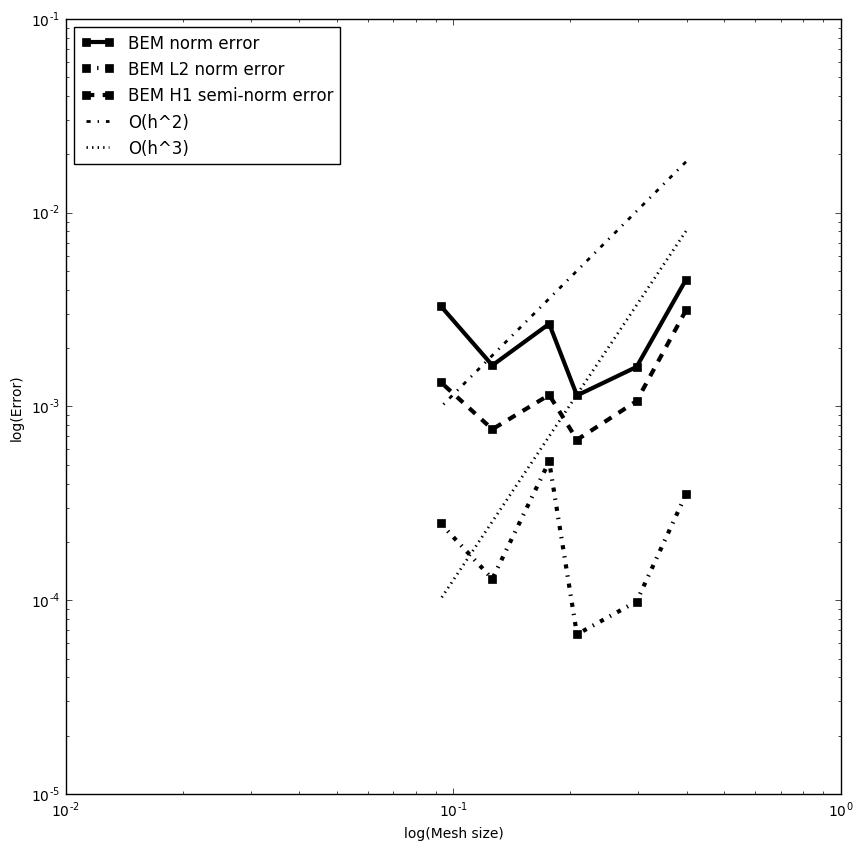

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)
inv_mesh_size =  np.true_divide(1, mesh_size)

mult = 1.35*abs(error_conv[len(mesh_size)//2]/mesh_size[len(mesh_size)//2])
o_mesh_size = np.multiply(mult, mesh_size)

mesh_pow_2 = np.multiply(mesh_size, mesh_size)
mult = 1.35*abs(error_conv[len(mesh_size)//2]/mesh_pow_2[len(mesh_size)//2])
o_mesh_pow_2 = np.multiply(mult, mesh_pow_2)

mesh_pow_3 = np.multiply(mesh_pow_2, mesh_size)
mult = 1.35*abs(BEM_u_error[len(mesh_size)//2]/mesh_pow_3[len(mesh_size)//2])
o_mesh_pow_3 = np.multiply(mult, mesh_pow_3)

plt.figure( figsize=(10, 10), dpi=100)
plt.loglog(mesh_size[0:len(error_conv)], error_conv, 'ks-', linewidth=3, label='BEM norm error')
plt.loglog(mesh_size[0:len(BEM_u_error)], BEM_u_error, 'ks-.', linewidth=3, label='BEM L2 norm error')
plt.loglog(mesh_size[0:len(BEM_lambda_error)], BEM_lambda_error, 'ks--', linewidth=3, label='BEM H1 semi-norm error')
# plt.loglog(mesh_size, o_mesh_size, 'k--', linewidth=2, label='O(h)')
plt.loglog(mesh_size, o_mesh_pow_2, 'k-.', linewidth=2, label='O(h^2)')
plt.loglog(mesh_size, o_mesh_pow_3, 'k:', linewidth=2, label='O(h^3)')
plt.legend(loc='upper left')
#plt.title('Sphere - beta = 0, p = 1')
plt.xlabel('log(Mesh size)')
plt.ylabel('log(Error)')
plt.show()

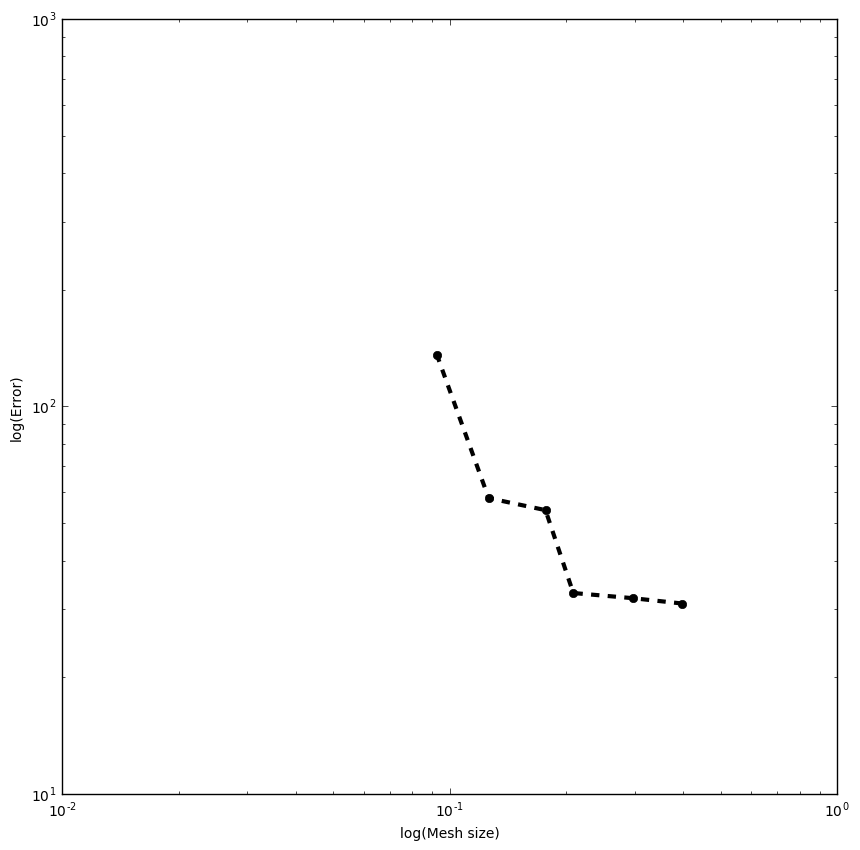

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

plt.figure( figsize=(10, 10), dpi=100)
plt.loglog(mesh_size[0:len(iter_num)], iter_num, 'ko--', linewidth=3)
# plt.legend(loc='lower right')
#plt.title('Sphere - beta = 0, p = 1')
plt.xlabel('log(Mesh size)')
plt.ylabel('log(Error)')
plt.show()